In [13]:
import os
import pickle
import pandas as pd
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import numpy as np
import warnings
import pandas as pd

from feature_engine.encoding import OneHotEncoder

from feature_engine.imputation import (
    ArbitraryNumberImputer,
    CategoricalImputer,
)
from feature_engine.selection import DropConstantFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sktime.transformations.series.summarize import WindowSummarizer
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.metrics import mean_absolute_percentage_error as mape

set_config(transform_output="pandas")
sns.set_context("talk")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
CATEGORICAL_COLUMNS = ["holiday_name"]
NUMERICAL_COLUMNS = [
    "holiday",
    "shutdown",
    "mini_shutdown",
    "shops_closed",
    "winter_school_holidays",
    "school_holidays",
    "blackout",
    "mov_change",
    "frankfurt_shutdown",
    "year",
    "month",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "weekend",
]
DATE_COLUMNS = ["date"]

TARGET_COLUMNS = "orders"
FEATRURE_COLUMNS = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS  # + DATE_COLUMNS
TRAIN_LEVEL = ["warehouse"]
MODEL_PATH = "model_registry"

# 0. Functions


## 0.1 Pipelines and transformers

In [15]:
pipeline = Pipeline(
    [
        # ('drop_na_lags', DropMissingData(variables=new_cols)),
        # Impute missing categorical except mean-encoded ones, normally happens in the test data
        (
            "missing_categoricals",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_COLUMNS
            ),
        ),
        # Impute 0 for missing numericals
        (
            "missing_numerical",
            ArbitraryNumberImputer(variables=NUMERICAL_COLUMNS, arbitrary_number=0),
        ),
        # OneHotEncode the rest of categorical
        (
            "onehot_encoding",
            OneHotEncoder(
                top_categories=6,
                variables=CATEGORICAL_COLUMNS,
                ignore_format=True,
            ),
        ),
        # Drop Constant features
        ("drop_constant", DropConstantFeatures(tol=1)),
        (
            "xgb",
            XGBRegressor(
                learning_rate=0.05,
                n_estimators=100,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                alpha=0.5,
                # lambda=1,
                min_child_weight=5,
                gamma=0,
            ),
        ),
    ]
)

In [16]:
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [17]:
lag_window_feats_2 = WindowSummarizer(
    lag_feature={
        "lag": [1, 7],  # Lag features.
        "mean": [[1, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [18]:
lag_window_feats_3 = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

## 0.2 Batch traning functions

In [19]:
def train_model_core(
    df: pd.DataFrame,
    train_level: list,
    feature_columns: list,
    target_column: str,
    pipeline: Pipeline,
    model_dir: str = "model_registry",
) -> pd.DataFrame:
    """This function run the train for a single level.

    Args:
        df (pd.DataFrame): A dataframe including level columns, features, and target columns
        train_level (list): training level i.e. `['warehouse', 'item_class']`
        feature_columns (list): Feature columns.
        target_column (str): traget columns should be a single string.
        model_dir (str, optional): Name of the directory for saving the model pickel files. Defaults to "model_registry".

    Returns:
        pd.DataFrame: A single row dataframe including the train level, model registry path, and error if we have any.
    """

    e = ""
    train_level_value = df[train_level].iloc[0, :].to_list()

    try:
        X = df[feature_columns]
        y = df[target_column]

        model = pipeline.fit(X, y)

        # saving the model to model registry
        os.makedirs(model_dir, exist_ok=True)
        model_string = "_".join(
            [f"{a}_{b}" for a, b in zip(train_level, train_level_value)]
        )
        model_path = os.path.join(model_dir, f"model_{model_string}.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(model, f)

    except Exception as e:
        print("e")

    train_df = pd.DataFrame(
        [train_level_value + ["_".join(train_level)] + [model_path] + [e]],
        columns=[*train_level, "train_level", "model_path", "error"],
    )

    return train_df

In [20]:
def score_model_core(
    df: pd.DataFrame,
    train_level: list,
    feature_columns: list,
    target_column: str,
    model_dir: str = "model_registry",
) -> pd.DataFrame:
    """Loading a model from model registry and inference.

    Args:
        df (pd.DataFrame): A dataframe including level columns, features, and target columns
        train_level (list): training level i.e. `['warehouse', 'item_class']`
        feature_columns (list): Feature columns.
        target_column (str): traget columns should be a single string.
        model_dir (str, optional): Name of the directory for saving the model pickel files. Defaults to "model_registry".

    Returns:
        pd.DataFrame: A dataframe including all input dataframe with forecast and error column added at the end.
    """
    e = ""
    df = df.copy()
    train_level_value = df[train_level].iloc[0, :].to_list()

    try:
        X = df[feature_columns]
        y = df[target_column]

        model_string = "_".join(
            [f"{a}_{b}" for a, b in zip(train_level, train_level_value)]
        )
        model_path = os.path.join(model_dir, f"model_{model_string}.pkl")
        with open(model_path, "rb") as f:
            model = pickle.load(f)

        df.loc[:, "forecast"] = model.predict(X)
        df.loc[:, "model_path"] = model_path

    except Exception as e:
        df.loc[:, "forecast"] = np.null
        df.loc[:, "model_path"] = np.null

    df.loc[:, "error"] = e
    return df

## 0.3 Recursive forecasting functions

In [21]:
def train_predict_sktime(
    df,
    feature_columns,
    target_columns,
    max_lag=365,
    pipeline=None,
    pipeline_lags_transformer=None,
    imputation="mean",
):

    print(f"warehouse: {df.warehouse.unique()[0]}")

    df.rename(columns={target_columns: "y"}, inplace=True)

    df_train = df.query("split=='train'")[feature_columns + ["y", "missing"]].copy()
    df_test = df.query("split=='test'")[feature_columns + ["y", "missing"]].copy()
    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=max_lag)))
        )
    ]
    if imputation == "mean":
        df_train["y"] = np.where(
            df_train["missing"] == 1, df_train["y"].mean(), df_train["y"]
        )
    elif imputation == "zero":
        df_train["y"] = np.where(df_train["missing"] == 1, 0, df_train["y"])
    else:
        raise ValueError("Imputation method not supported")

    df_train_lags_only = pipeline_lags_transformer.fit_transform(df_train[["y"]])

    new_cols = list(df_train_lags_only.columns)

    df_train_lags = pd.concat([df_train, df_train_lags_only], axis=1)
    # drop missing targets
    df_train_lags = df_train_lags.query("missing == 0")

    df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
    
    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags["y"]

    model = pipeline.fit(X_train, y_train)

    for forecast_time in df_test.index:
        df_predict_lags_only = pipeline_lags_transformer.transform(df_predict[["y"]])
        X_test = pd.concat([df_predict, df_predict_lags_only], axis=1)
        X_test_ = X_test.loc[[forecast_time]]
        y_pred = model.predict(X_test_[feature_columns + new_cols])
        df_predict.loc[[forecast_time], "y"] = y_pred

    df_predict.rename(columns={"y": target_columns}, inplace=True)

    return df_predict.query("split=='test' and missing==0")

## 0.4 Loading data and evaluation functions

In [35]:
def load_data():
    PATH = "../data/"
    df_train = pd.read_csv(
        f"{PATH}train_new.csv", parse_dates=["date"], index_col="date"
    )
    df_train["split"] = "train"

    df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
    df_test["split"] = "test"

    cols = df_train.columns
    df_test = df_test[cols]

    df = pd.concat([df_train, df_test], axis=0)

    return df

In [23]:
def load_test_data(test_days=90):
    PATH = "../data/"
    df_train = pd.read_csv(
        f"{PATH}train_new.csv", parse_dates=["date"], index_col="date"
    )
    df_train["orders_copy"] = df_train["orders"]

    max_date = df_train.index.max() - datetime.timedelta(days=test_days)
    df_train.loc[df_train.index > max_date, "split"] = "test"
    df_train.loc[df_train.index <= max_date, "split"] = "train"
    df_train["orders"] = np.where(
        df_train["split"] == "test", np.nan, df_train["orders"]
    )

    return df_train


def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# 1. Test models on holdout period

In [24]:
# load the data
df = load_test_data(test_days=90)

## 1.1 Recursive forecast

In [25]:
df_forecast = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [26]:
df_forecast_2 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=7,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_2,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [27]:
df_forecast_3 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_3,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


## 1.2 Batch training without lags

In [28]:
df.query(f"split=='train' and not {TARGET_COLUMNS}.isnull()").groupby(
    TRAIN_LEVEL
).apply(
    train_model_core,
    TRAIN_LEVEL,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    pipeline,
    model_dir=MODEL_PATH,
    include_groups=True,
).reset_index(
    drop=True
)

,warehouse,train_level,model_path,error
0,Brno_1,warehouse,model_registry\model_warehouse_Brno_1.pkl,
1,Budapest_1,warehouse,model_registry\model_warehouse_Budapest_1.pkl,
2,Frankfurt_1,warehouse,model_registry\model_warehouse_Frankfurt_1.pkl,
3,Munich_1,warehouse,model_registry\model_warehouse_Munich_1.pkl,
4,Prague_1,warehouse,model_registry\model_warehouse_Prague_1.pkl,
5,Prague_2,warehouse,model_registry\model_warehouse_Prague_2.pkl,
6,Prague_3,warehouse,model_registry\model_warehouse_Prague_3.pkl,


In [29]:
df_forecast_4 = (
    df.query(f"split=='test'")
    .reset_index()
    .groupby(TRAIN_LEVEL)
    .apply(
        score_model_core,
        TRAIN_LEVEL,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        model_dir=MODEL_PATH,
        include_groups=True,
    )
    .reset_index(drop=True)
    .query("missing==0")
)

## 1.3. Evaluation of models against holdout period

In [30]:
df_final = (
    df_forecast[["id", "warehouse", "date", "orders", "orders_copy"]]
    .merge(
        df_forecast_2[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_2"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_3[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_3"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_4[["id", "warehouse", "date", "forecast"]],
        on=["id", "warehouse", "date"],
        how="left",
    )
)
df_final["ensemble"] = df_final[["orders", "orders_2", "orders_3", "forecast"]].mean(
    axis=1
)
df_final["ensemble_2"] = df_final[["orders", "orders_3"]].mean(axis=1)

In [31]:
print(wmape(df_forecast["orders_copy"], df_forecast["orders"]))
print(wmape(df_forecast_2["orders_copy"], df_forecast_2["orders"]))
print(wmape(df_forecast_3["orders_copy"], df_forecast_3["orders"]))
print(wmape(df_forecast_4["orders_copy"], df_forecast_4["forecast"]))
print(wmape(df_final["orders_copy"], df_final["ensemble"]))
print(wmape(df_final["orders_copy"], df_final["ensemble_2"]))

0.09498328736613884
0.13794846638796932
0.0913451071399974
0.15626426323525683
0.11605911326059057
0.0925250461031782


In [32]:
print(mape(df_forecast["orders_copy"], df_forecast["orders"]))
print(mape(df_forecast_2["orders_copy"], df_forecast_2["orders"]))
print(mape(df_forecast_3["orders_copy"], df_forecast_3["orders"]))
print(mape(df_forecast_4["orders_copy"], df_forecast_4["forecast"]))
print(mape(df_final["orders_copy"], df_final["ensemble"]))
print(mape(df_final["orders_copy"], df_final["ensemble_2"]))

0.09805396784999384
0.136761847065319
0.09200489504176833
0.1598731638948882
0.11817483262210743
0.09438475083630155


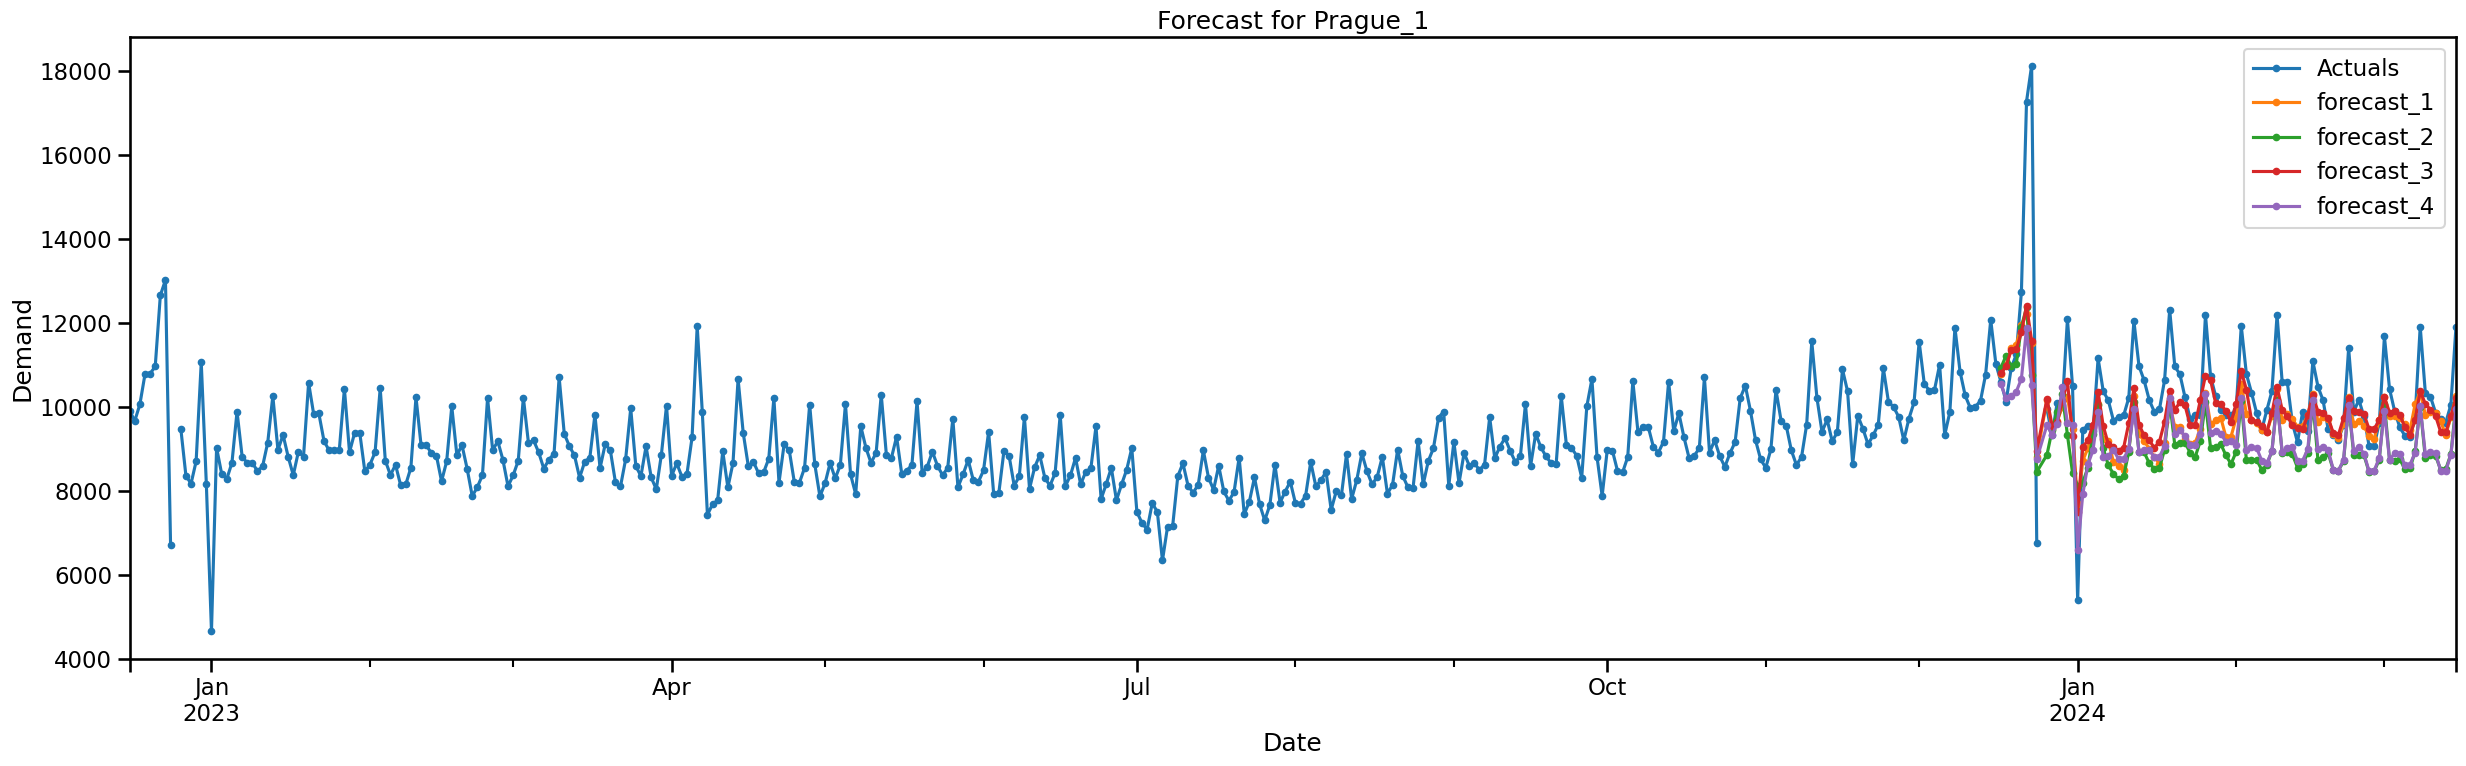

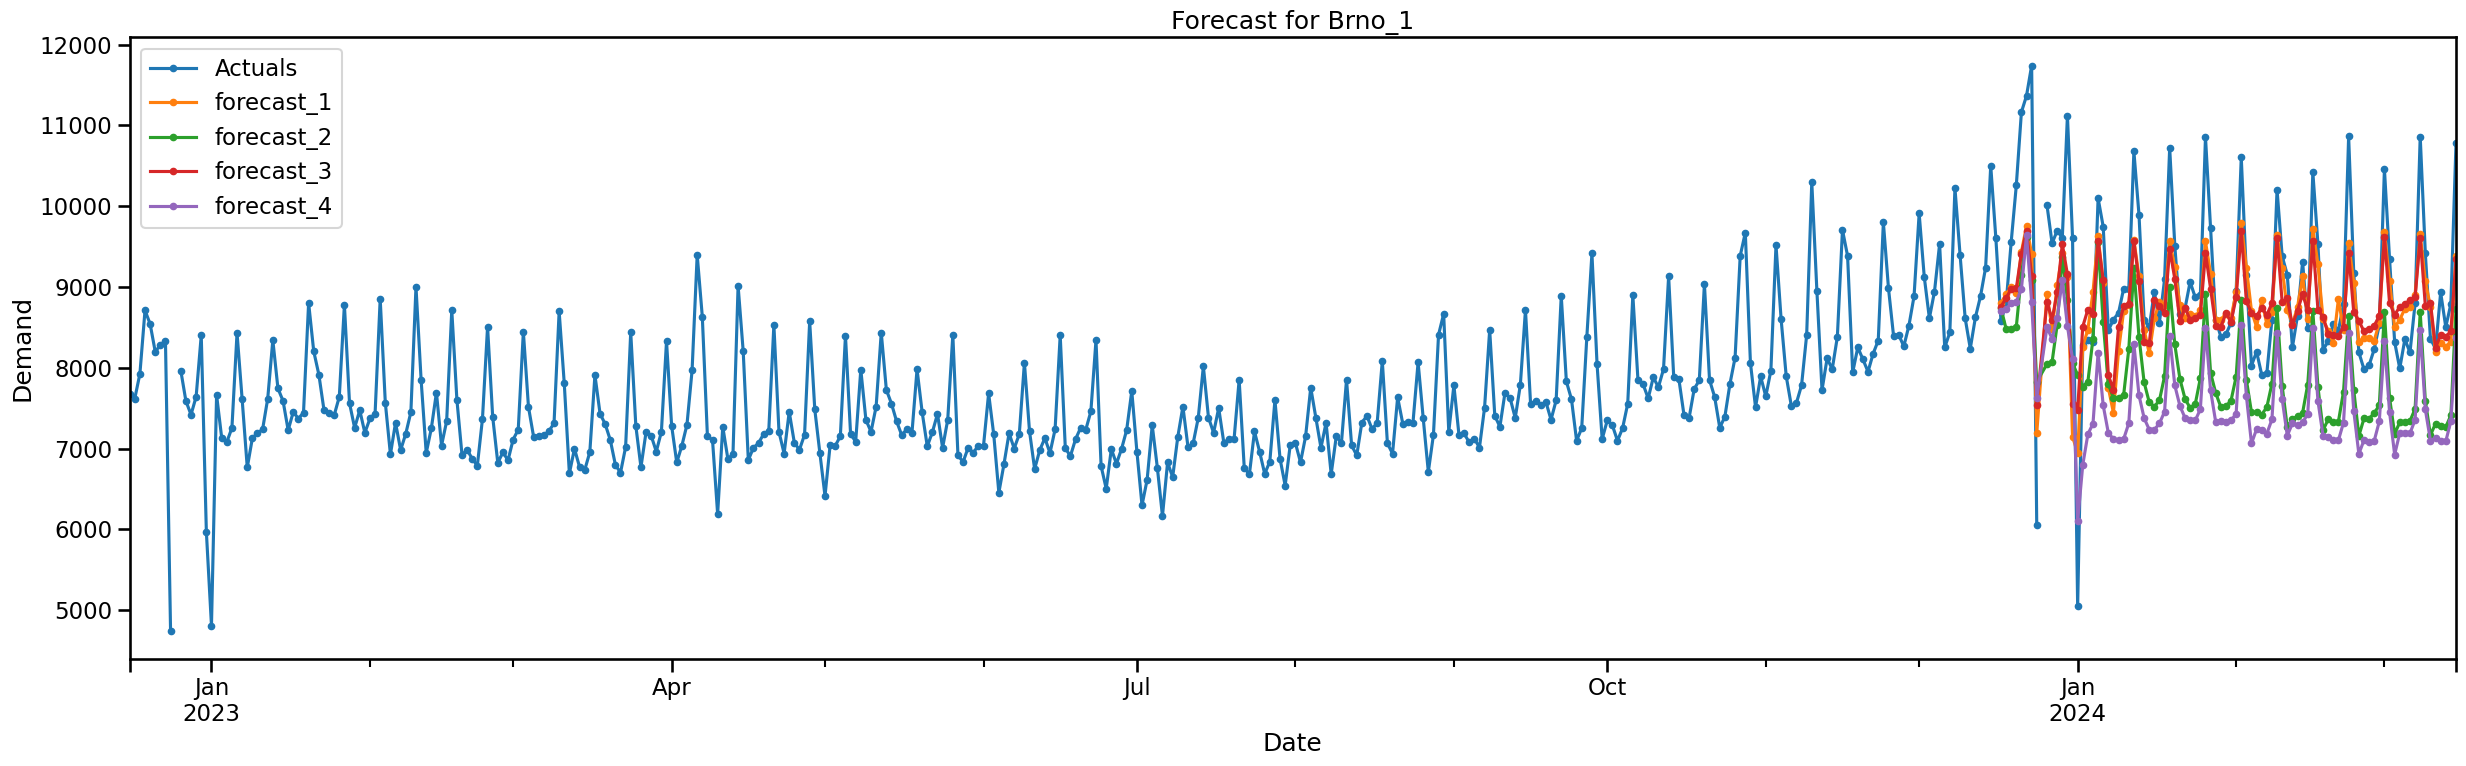

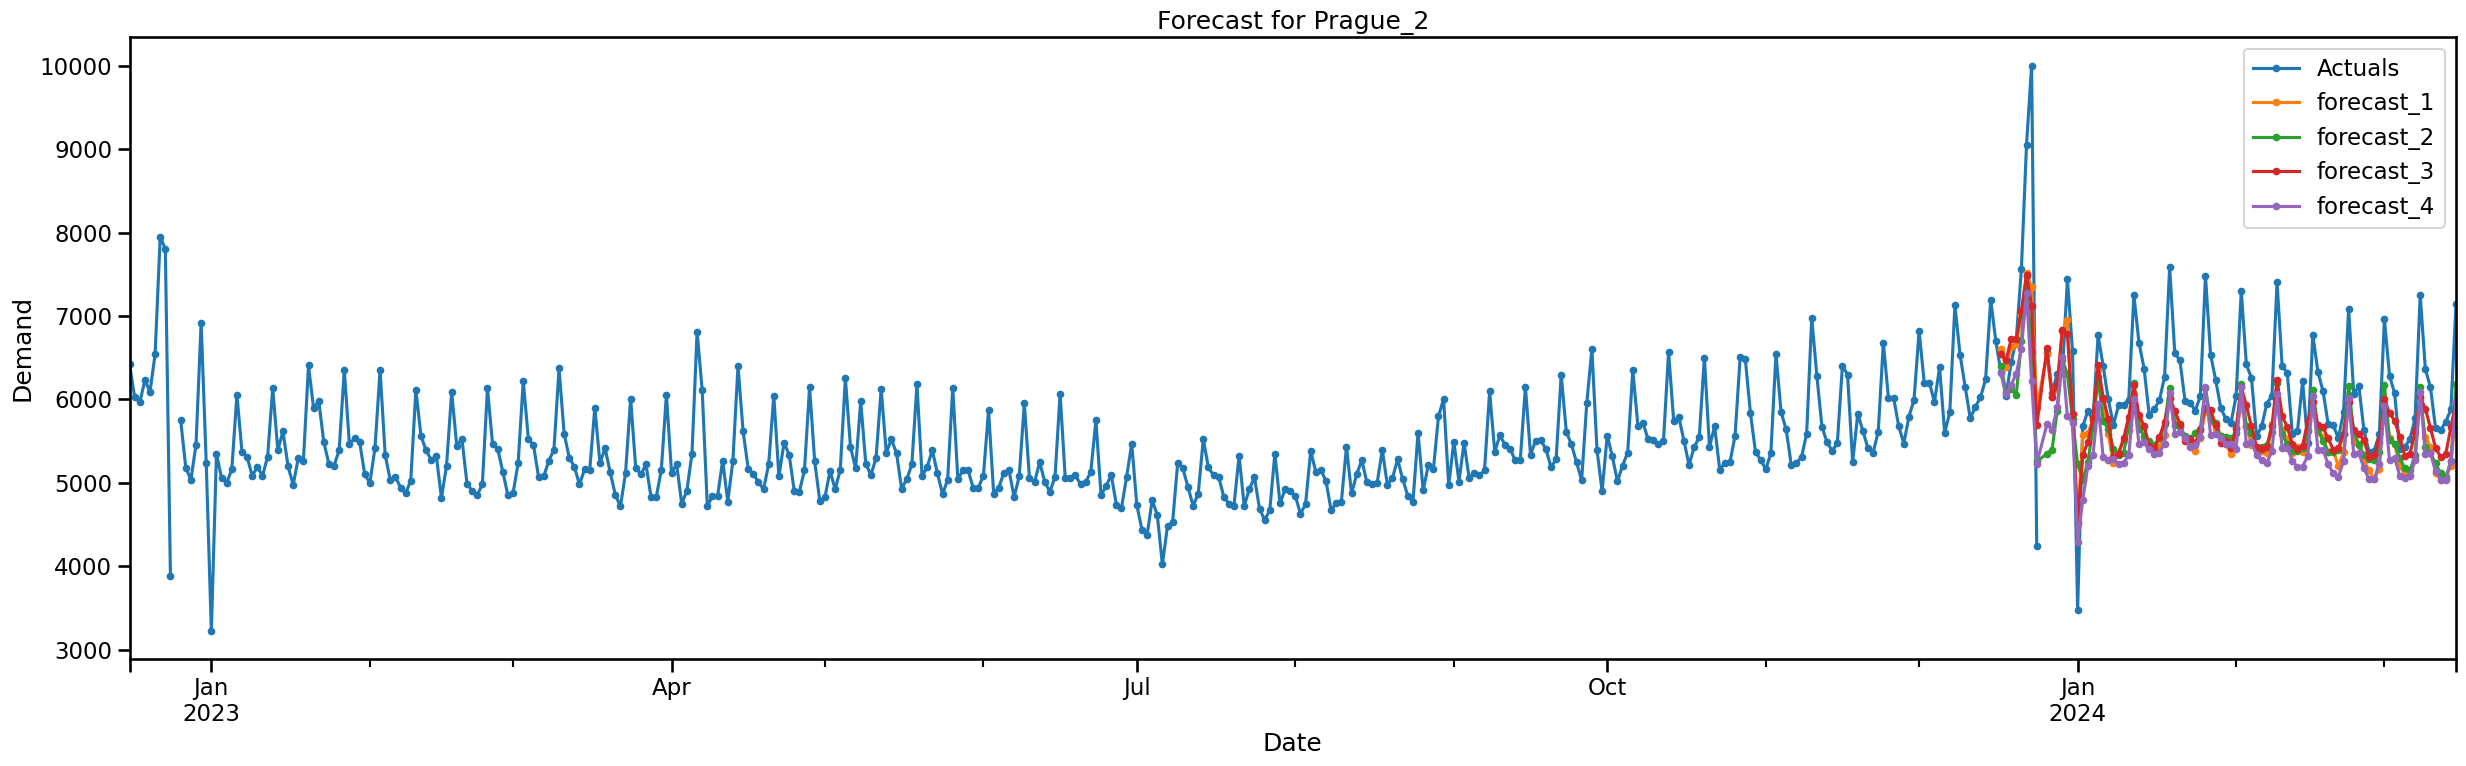

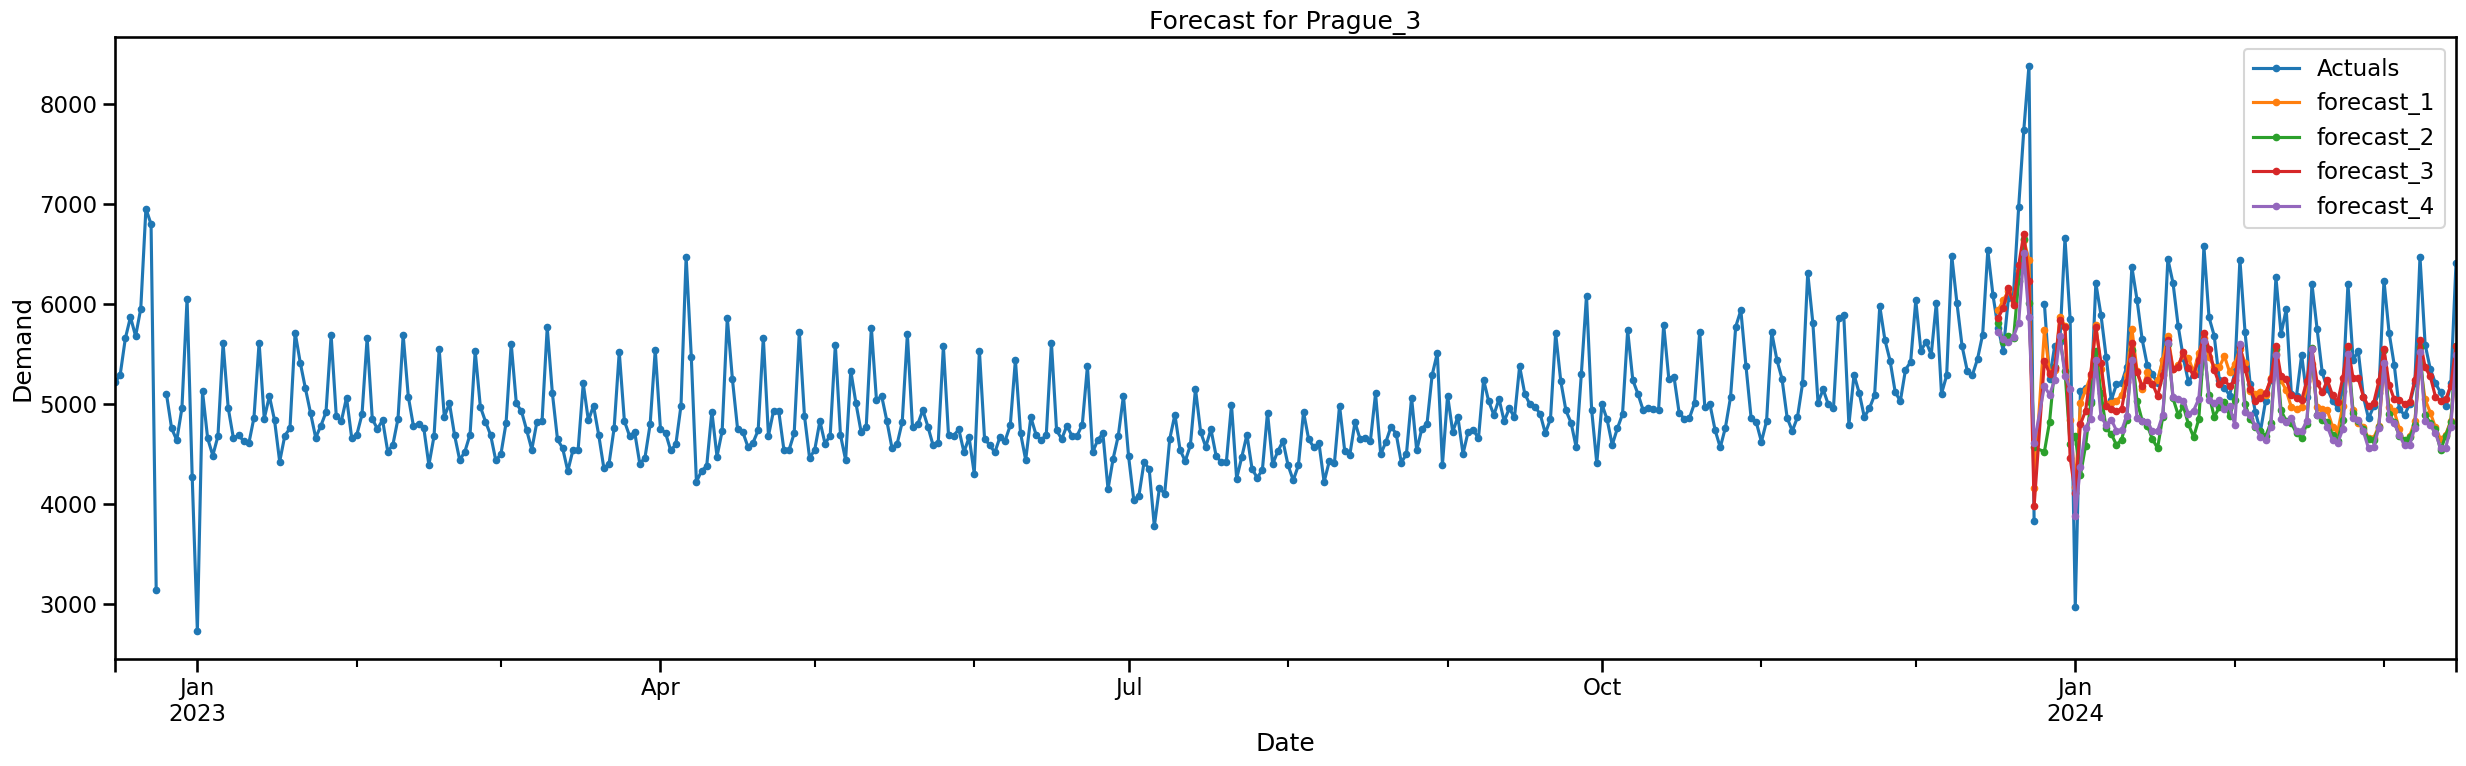

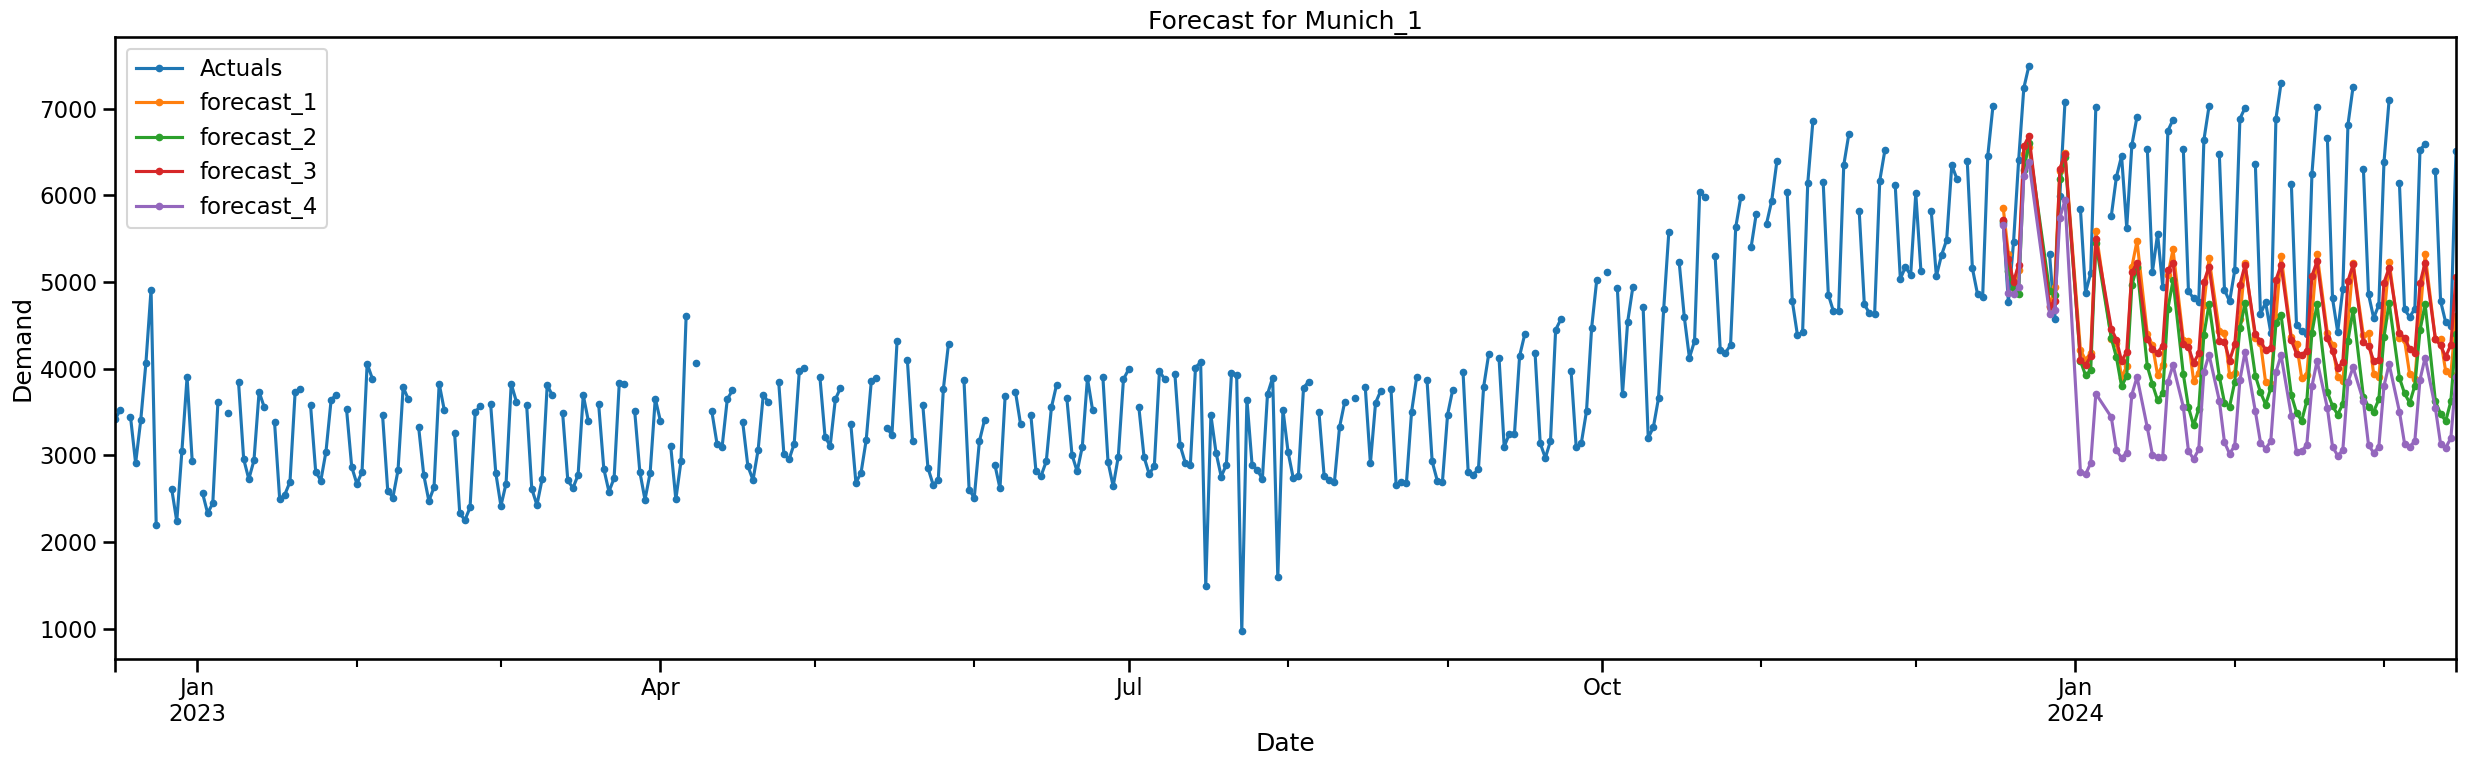

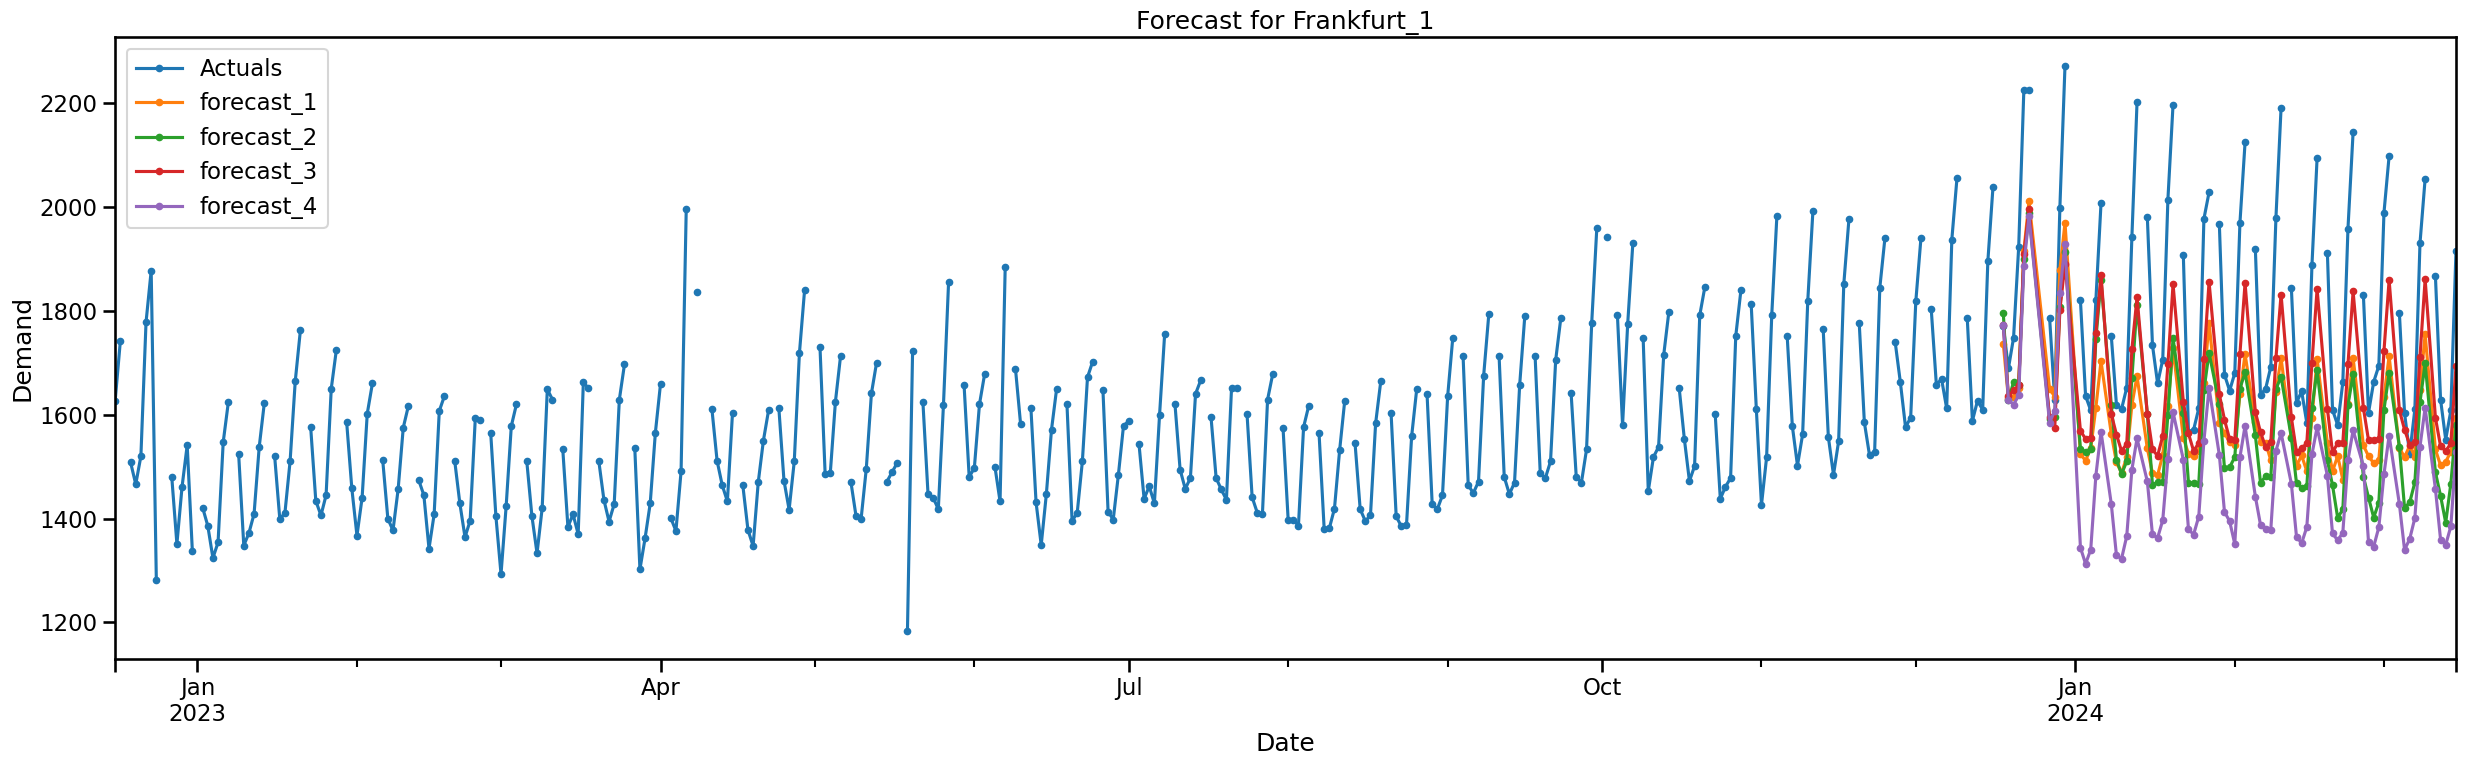

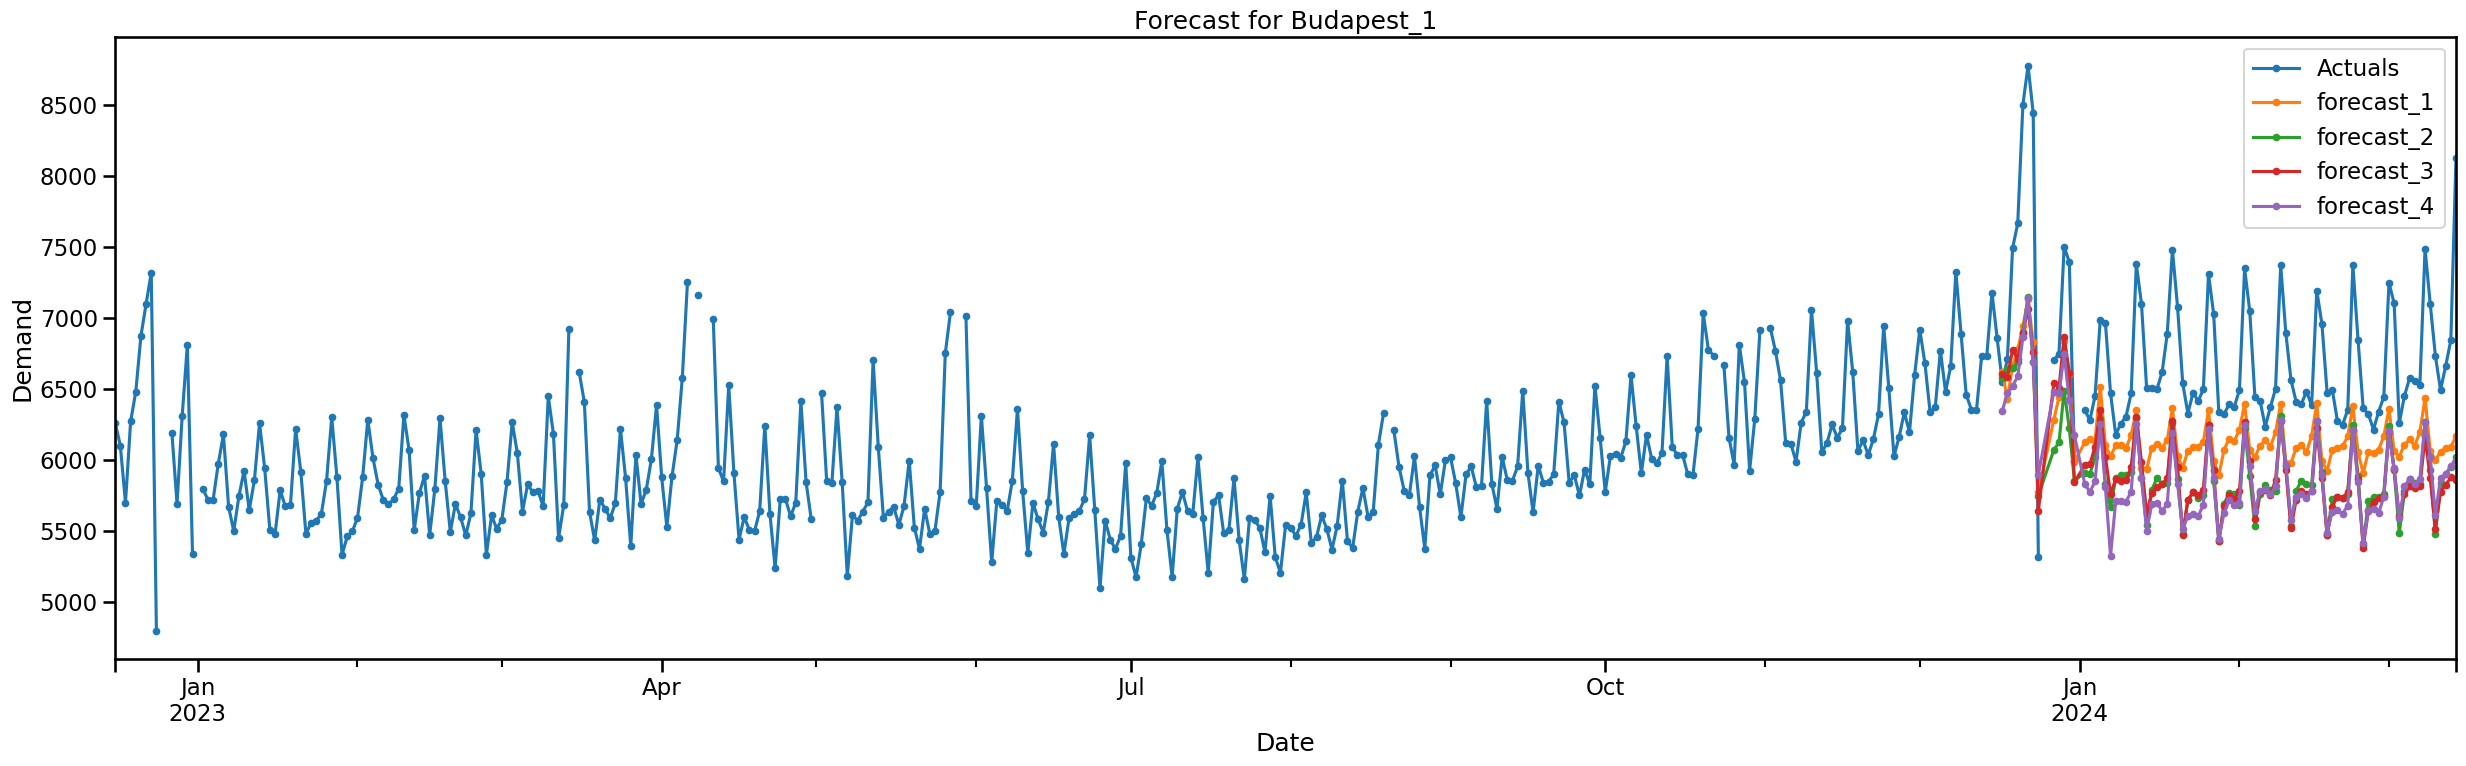

In [33]:
# warehouse= "Prague_3"
for warehouse in df.warehouse.unique():
    fig, ax = plt.subplots(figsize=[25, 7])
    min_date = df.query(
        f"split=='train' and warehouse=='{warehouse}'"
    ).index.max() - datetime.timedelta(days=365)
    # filter dates after min_date
    # df.query(f"split=='train' and warehouse=='{warehouse}'").loc[min_date:].plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df.query(f"warehouse=='{warehouse}'").loc[min_date:].plot(
        y="orders_copy", marker=".", figsize=[25, 8], legend=None, ax=ax
    )
    df_forecast.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df_forecast_2.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df_forecast_3.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df_forecast_4.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="forecast", marker=".", figsize=[25, 8], legend=None, ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Demand")
    ax.set_title("Forecast for {}".format(warehouse))
    ax.legend(["Actuals", "forecast_1", "forecast_2", "forecast_3", "forecast_4"])
    plt.tight_layout()

# 2. Forecasting for test dataset


In [36]:
df = load_data()

In [37]:
df_forecast = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [38]:
df_forecast_2 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=7,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_2,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [39]:
df_forecast_3 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_3,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [40]:
df.query(f"split=='train' and not {TARGET_COLUMNS}.isnull()").groupby(
    TRAIN_LEVEL
).apply(
    train_model_core,
    TRAIN_LEVEL,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    pipeline,
    model_dir=MODEL_PATH,
    include_groups=True,
).reset_index(
    drop=True
)

df_forecast_4 = (
    df.query(f"split=='test'")
    .reset_index()
    .groupby(TRAIN_LEVEL)
    .apply(
        score_model_core,
        TRAIN_LEVEL,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        model_dir=MODEL_PATH,
        include_groups=True,
    )
    .reset_index(drop=True)
    .query("missing==0")
)

In [41]:
df_final = (
    df_forecast[["id", "warehouse", "date", "orders"]]
    .merge(
        df_forecast_2[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_2"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_3[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_3"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_4[["id", "warehouse", "date", "forecast"]],
        on=["id", "warehouse", "date"],
        how="left",
    )
)
df_final["ensemble"] = df_final[["orders", "orders_2", "orders_3", "forecast"]].mean(
    axis=1
)
df_final["ensemble_2"] = df_final[["orders", "orders_3"]].mean(axis=1)

In [42]:
df_final

,id,warehouse,date,orders,orders_2,orders_3,forecast,ensemble,ensemble_2
0,Brno_1_2024-03-16,Brno_1,2024-03-16,9182.302734,9472.541016,9258.821289,9393.029297,9326.673584,9220.562012
1,Brno_1_2024-03-17,Brno_1,2024-03-17,8187.700195,8340.394531,8234.978516,8406.012695,8292.271484,8211.339355
2,Brno_1_2024-03-18,Brno_1,2024-03-18,8227.477539,8328.238281,8302.093750,8246.625977,8276.108887,8264.785645
3,Brno_1_2024-03-19,Brno_1,2024-03-19,8358.456055,8583.426758,8469.151367,8467.952148,8469.746582,8413.803711
4,Brno_1_2024-03-20,Brno_1,2024-03-20,8444.336914,8671.654297,8496.528320,8446.275391,8514.698730,8470.432617
...,...,...,...,...,...,...,...,...,...
392,Prague_3_2024-05-11,Prague_3,2024-05-11,5714.461914,4920.341309,5728.420410,5516.524414,5469.937012,5721.441162
393,Prague_3_2024-05-12,Prague_3,2024-05-12,5484.274902,4832.433105,5483.843262,5339.227051,5284.944580,5484.059082
394,Prague_3_2024-05-13,Prague_3,2024-05-13,5360.880859,4780.027832,5362.995605,5064.521484,5142.106445,5361.938232
395,Prague_3_2024-05-14,Prague_3,2024-05-14,5184.764160,4731.538574,5224.788086,4983.534180,5031.156250,5204.776123


In [43]:
PATH = "../data/submission/"
df_final.to_csv(f"{PATH}all_sumissions.csv", index=False)
df_final[["id", "orders"]].to_csv(f"{PATH}sumission_1.csv", index=False)
df_final[["id", "orders_2"]].rename(columns={"orders_2": "orders"}).to_csv(
    f"{PATH}sumission_2.csv", index=False
)
df_final[["id", "orders_3"]].rename(columns={"orders_3": "orders"}).to_csv(
    f"{PATH}sumission_3.csv", index=False
)
df_final[["id", "forecast"]].rename(columns={"forecast": "orders"}).to_csv(
    f"{PATH}sumission_4.csv", index=False
)
df_final[["id", "ensemble"]].rename(columns={"ensemble": "orders"}).to_csv(
    f"{PATH}sumission_5.csv", index=False
)
df_final[["id", "ensemble_2"]].rename(columns={"ensemble_2": "orders"}).to_csv(
    f"{PATH}sumission_6.csv", index=False
)